# Week 4 - Partial Least Squares Regression

In [1]:
import scipy as sp, numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

data = loadmat('./wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
Y = Y[:, 4]
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

In [2]:
#print(X)
#print(X.shape)
#print(X.dtype)
#print(Y)
#print(Y.shape)
#print(Y.dtype)

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principle components do you need for each to explain 90% of the variance? Discuss your findings.

Hint: Be sure to normalize each dataset as needed for the analysis.

In [3]:
import scipy
from scipy import stats

X_zscored = scipy.stats.mstats.zscore(X, axis=0)
Y_mean = np.mean(Y)
Y_std = np.std(Y)
Y_zscored = scipy.stats.zscore(Y)

In [4]:
#print(X_zscored)
#print(X_zscored.shape)
#print(X_zscored.dtype)
#print(Y_zscored)
#print(Y_zscored.shape)
#print(Y_zscored.dtype)

In [5]:
def one_minus_ratio(A_model, A_observed):
    # np.subtract ~ element-wise subtraction 
    # np.square ~ element-wise squaring
    # np.sum ~ sum of all elements
    
    sum_of_squared_differences = np.sum(np.square(np.squeeze(np.subtract(A_model,A_observed))))
    squared_observed = np.sum(np.square(A_observed))
    
    #print("Results for one_minus_ratio function:")
    #print("observed shape: {}".format(A_observed.shape))
    #print("model shape: {}\n".format(A_model.shape))
    
    return(1-(sum_of_squared_differences/squared_observed))

# tests for function: one_minus_ratio
assert(one_minus_ratio(X_zscored,X_zscored)==1)
assert(one_minus_ratio(Y_zscored,Y_zscored)==1)
assert(one_minus_ratio(X_zscored,X)!=1)
assert(one_minus_ratio(Y_zscored,Y)!=1)

def R_2(A_scores, A_loadings, A_observed):
    # creates A_model for input into one_minus_ratio function
    A_loadings_transpose = (np.ndarray.transpose(A_loadings))
    A_model = np.squeeze(np.dot((A_scores), A_loadings_transpose))
    
    #print("Results for R_2 function:")
    #print("observed shape: {}".format(A_observed.shape))
    #print("scores shape: {}".format(A_scores.shape))
    #print("loadings shape: {}".format(A_loadings.shape))
    #print("model shape: {}\n".format(A_model.shape))
    
    return(one_minus_ratio(A_model, A_observed))

92.32% of the variance in Y has been explained at 4 principal components.
90.6% of the variance in X has been explained at 18 principal components.


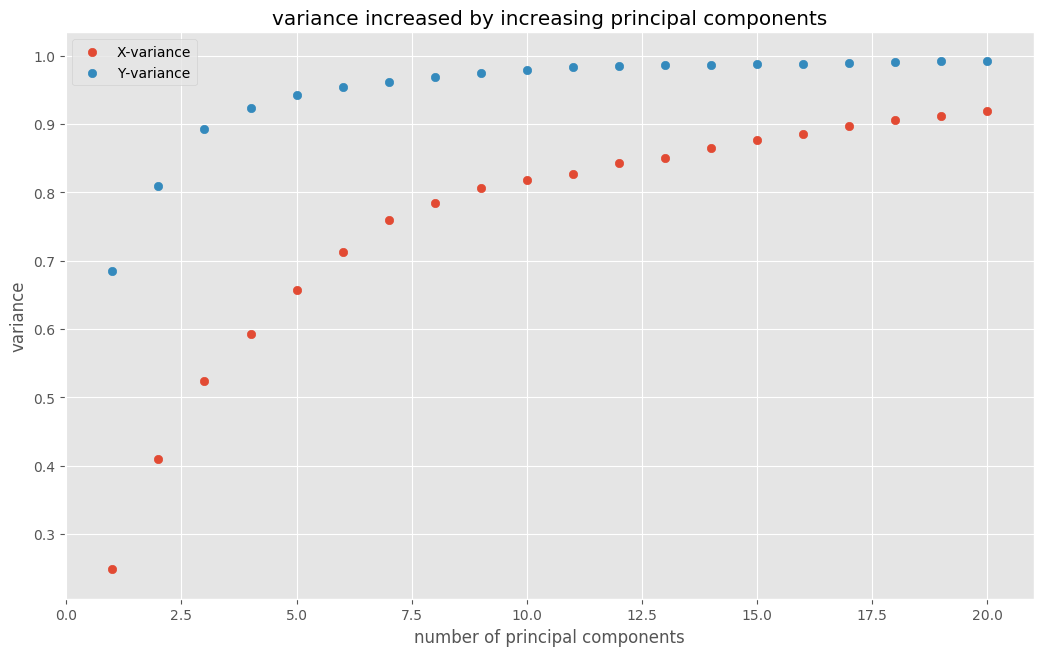

In [6]:
from sklearn.cross_decomposition import PLSRegression

R_2_X_holder_using_function_I_wrote= [] # holds R_squared values for variance in X defined by function I wrote
R_2_Y_holder_lazy = [] # holds R_squared values for variance in Y given by PLSR
#R_2_Y_holder_using_function_I_wrote = [] # # holds R_squared values for variance in Y defined by function I wrote

dummy_countx = True
dummy_county = True

max_number_of_pc = 20

for i in range(max_number_of_pc):
    #print("{} principal components.".format(i+1))
    pls= PLSRegression(n_components=(i+1), max_iter=500)
    pls.fit(X_zscored,Y_zscored)
        
    R_2_X_holder_using_function_I_wrote.append(R_2(pls.x_scores_, pls.x_loadings_, X_zscored))
    if R_2_X_holder_using_function_I_wrote[-1] >= 0.9 and dummy_countx:
        print("{}% of the variance in X has been explained at {} principal components.".format((round(100*R_2_X_holder_using_function_I_wrote[-1], 2)), (i+1)))
        dummy_countx = False
    
    
    Y_model = np.squeeze(pls.predict(X_zscored))
    R_2_Y_holder_lazy.append(one_minus_ratio(Y_model, Y_zscored))
    if R_2_Y_holder_lazy[-1] >= 0.9 and dummy_county:
        print("{}% of the variance in Y has been explained at {} principal components.".format((round(100*R_2_Y_holder_lazy[-1], 2)), (i+1)))
        dummy_county = False
        
    #R_2_Y_holder_using_function_I_wrote.append(R_2(pls.y_scores_, pls.y_loadings_, Y_zscored))
    #if R_2_Y_holder_using_function_I_wrote[-1] >= 0.9:
    #    print("{}% of the variance in Y has been explained at {} principal components.".format((round(100*R_2_Y_holder_using_function_I_wrote[-1], 2)), (i+1)))

    
plt.figure(1, figsize=(12.5, 7.5), dpi=100)

plt.title("variance increased by increasing principal components")
plt.scatter(np.arange(1,max_number_of_pc+1), R_2_X_holder_using_function_I_wrote, label="X-variance")
plt.scatter(np.arange(1,max_number_of_pc+1), R_2_Y_holder_lazy, label="Y-variance")
plt.xlabel("number of principal components")
plt.ylabel("variance")
plt.legend()

#plt.subplot(313)
#plt.scatter(np.arange(1,max_number_of_pc+1), R_2_Y_holder_using_function_I_wrote, label="Y-variance")
#plt.xlabel("number of principal components")
#plt.legend()

plt.show()

I will be using 4 principal components since that is enough to explain the variance in Y (to above 90%).

We can see that it takes more components to explain the variance in X than in Y because it has much more information and variance to account for than Y does. (Y is one column, X is 102).

#### (2) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

taken from _Multi- and Megavariate Data Analysis Basic Principles and Application, Volume 1 by Eriksson et al._

t scores (X): t1 vs. t2, ...

t score plots are windows in the X space displaying the observations as situated on the projection plane or hyperplane.

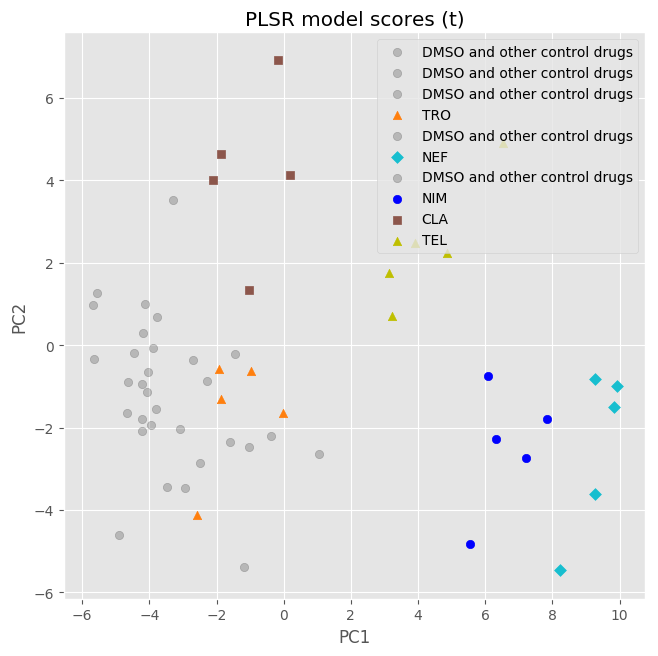

In [7]:
pls4 = PLSRegression(n_components=(4), max_iter=500)
pls4.fit(X_zscored,Y_zscored)

#print(conditions)
#print(drugList)
#print(drugListToxic)

x_scores_pc1_values = pls4.x_scores_[:, 0] # t
x_scores_pc2_values = pls4.x_scores_[:, 1]

#y_scores_pc1_values = pls4.y_scores_[:, 0] u
#y_scores_pc2_values = pls4.y_scores_[:, 1]

plt.figure(2, figsize=(7.5, 7.5), dpi=100)

#kcolors = ['w' if value == 0 'b' elif value == 1 'r' elif value == 2 'g' elif value == 3 'c' elif value == 4 'm' elif value == 5 'y' elif value == 6 for value in k]

plt.scatter(x_scores_pc1_values[0:11], x_scores_pc2_values[0:11], c='k', alpha=0.2, label="DMSO and other control drugs")
plt.scatter(x_scores_pc1_values[12:17], x_scores_pc2_values[12:17], c='k', alpha=0.2, label="DMSO and other control drugs")
plt.scatter(x_scores_pc1_values[18:23], x_scores_pc2_values[18:23], c='k', alpha=0.2, label="DMSO and other control drugs")
plt.scatter(x_scores_pc1_values[24:29], x_scores_pc2_values[24:29], c='tab:orange', marker="^", label="TRO")
plt.scatter(x_scores_pc1_values[30:35], x_scores_pc2_values[30:35], c='k', alpha=0.2, label="DMSO and other control drugs")
plt.scatter(x_scores_pc1_values[36:41], x_scores_pc2_values[36:41], c='tab:cyan', marker='D', label="NEF")
plt.scatter(x_scores_pc1_values[42:47], x_scores_pc2_values[42:47], c='k', alpha=0.2, label="DMSO and other control drugs")
plt.scatter(x_scores_pc1_values[48:53], x_scores_pc2_values[48:53], c='b', label = "NIM")
plt.scatter(x_scores_pc1_values[54:59], x_scores_pc2_values[54:59], c='tab:brown', marker='s', label="CLA")
plt.scatter(x_scores_pc1_values[60:65], x_scores_pc2_values[60:65], c='y', marker='^', label="TEL")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PLSR model scores (t)")    
plt.show()

#plt.subplot(212)
#plt.scatter(y_scores_pc1_values, y_scores_pc2_values)
#plt.xlim(-12.5,12.5)
#plt.ylim(-12.5,12.5) 


#### (3) Create the loadings plot corresponding to (2). 
#### Interpret the results shown on the plot.

_taken from Multi- and Megavariate Data Analysis Basic Principles and Application, Volume 1 by Eriksson et al._

__p loadings (X): p1 vs. p2, ...__

p loading plots show the importance of the X variables in the approximation of the X matrix.

__w loadings (X): w1 vs. w2, ...__

w loading plots display the correlation between the X variables, in the first dimension, or the residuals of the X variables in subsequent dimensions, and the Y or Y residuals scores u(Y).

The __w__'s are the weights that combine the X variables (first dimension) or the residuals of the X variables (subsequent dimensions) to form the scores t. These weights are selected so as to maximize the covariance between t and u, thereby indirectly t and Y.

X variables with large w's (positive or negative) are highly correlated wth u(Y).

Variables with large w's are situated far away from the origin (on the positive or negative side on the plot.

__w$^*$ loadings (X): w$^*$1 vs. w$^*$2, ...__

For every PLS dimension the w$^*$'s are the weights that combine the original X variables (not their residuals as with w) to form the scores t.

w$^*$ is computed as follows:

$w^*=w(p'w)^{-1}$

From this formula, we can see that w$^*$ is equal to w in the first dimension.

Also, when p is equal to w (for all dimensions), w$^*$ is equal to w because w'w (and p'w) is equal to 1.

__Relation of w$^*$ to the PLS regression coefficients__

For a given response Y, the PLS regression coefficients are (for the model Y=XB):

$b=w(p'w)^{-1}c'$

$b=w^*c'$ and $y=xw^*c'$

Hence, w$^*$ is directly related to the PLS regression coefficients.

__c loadings (Y): c1 vs. c2, ...__ 

c loading plots display the correlation between the Y variables and t(X). The __c__'s are the weights that combine the Y variables with the scores __u__, so as to maximize their correlation with X. Y variables with __large c's__ are highly correlated with t(X).

__wc or w$^*$c loadings (X&Y): wc1 vs. wc2, ...__

wc or w$^*$c loading plots show __both__ the X-weights (w __or__ w$^*$) and Y-weights (c), and thereby the correlation structure between X and Y. One sees how the X and Y variables combine in the projections, and how the X variables relate to Y.

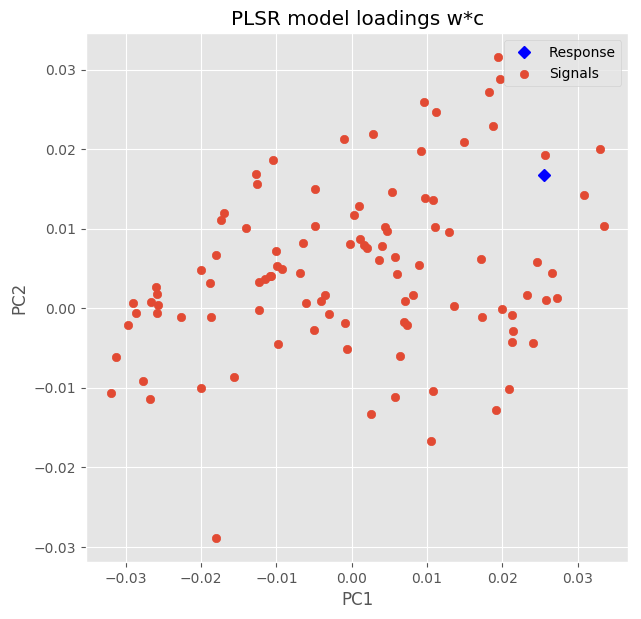

In [8]:
x_loadings_pc1_values = pls4.x_loadings_[:, 0] # p
x_loadings_pc2_values = pls4.x_loadings_[:, 1] 

y_loadings_pc1_values = pls4.y_loadings_[:, 0] # q
y_loadings_pc2_values = pls4.y_loadings_[:, 1] 

x_weights_pc1_values  = pls4.x_weights_[:,0] # w
x_weights_pc2_values  = pls4.x_weights_[:,1]

w_star =(np.matmul(pls4.x_weights_, np.linalg.inv(np.matmul(pls4.x_loadings_.T, pls4.x_weights_))))

x_weight_star_pc1_values  = w_star[:,0] # w*
x_weight_star_pc2_values  = w_star[:,1]

x_rotations_pc1_values  = pls4.x_rotations_[:,0]
x_rotations_pc2_values  = pls4.x_rotations_[:,1]

y_weights_pc1_values  = pls4.y_weights_[:,0] # c
y_weights_pc2_values  = pls4.y_weights_[:,1]

plt.figure(3, figsize=(7, 7), dpi=100)

# w*c vs. w*c
plt.plot(0.15*y_loadings_pc1_values,0.15*y_loadings_pc2_values, 'bD', label = "Response") # i had to scale down the loading (this should be a legal move)
plt.scatter(np.multiply(x_weight_star_pc1_values, y_weights_pc1_values), np.multiply(x_weight_star_pc2_values, y_weights_pc2_values), label="Signals")
plt.legend()
plt.title("PLSR model loadings w*c")
plt.xlabel("PC1")
plt.ylabel("PC2")

#plt.subplot(412) # this is equivalent to the graph above, I think, rotations c vs. rotations c
#plt.plot(0.15*y_loadings_pc1_values,0.15*y_loadings_pc2_values, 'bD')
#plt.scatter(np.multiply(x_rotations_pc1_values, y_weights_pc1_values), np.multiply(x_rotations_pc2_values, y_weights_pc2_values))

#plt.subplot(413) # wc vs. wc
#plt.plot(0.15*y_loadings_pc1_values,0.15*y_loadings_pc2_values, 'bD')
#plt.scatter(np.multiply(x_weights_pc1_values, y_weights_pc1_values), np.multiply(x_weights_pc2_values, y_weights_pc2_values))

#plt.subplot(414) #p vs. p
#plt.plot(y_loadings_pc1_values,y_loadings_pc2_values, 'bD')
#plt.scatter(x_loadings_pc1_values,x_loadings_pc2_values)

plt.show()

We see that LDH response is associated with positive magnitude of PC1 and a postive magnitude of PC2. This means that any point in the positive quadrant (+PC1, +PC2) is associated with LDH response. Cosgrove et al. gives the example of p-p38 as one such signal. In the negative quadrant (-PC1, -PC2), signals here are associated negatvely with LDH response. Cosgrove et al. gives the example of p-p70.

#### (4) Recreate a 4-principle component model using PLSR with just the final 4 phosphoprotein model. Plot predicted LDH versus observed LDH for this model. Report the model fitness (R^2). Define here how you are calculating R^2.


The R-squared value for predicting z-scored Y using z-scored observed X and evaluating against z-scored observed Y is 0.9168
The Cosgrove et al. defined R-squared value is 0.9232
The Pearson product-moment correlation coefficient is 0.9608
The line of best fit has the following equation  
0.9232 x + 2.521e-17



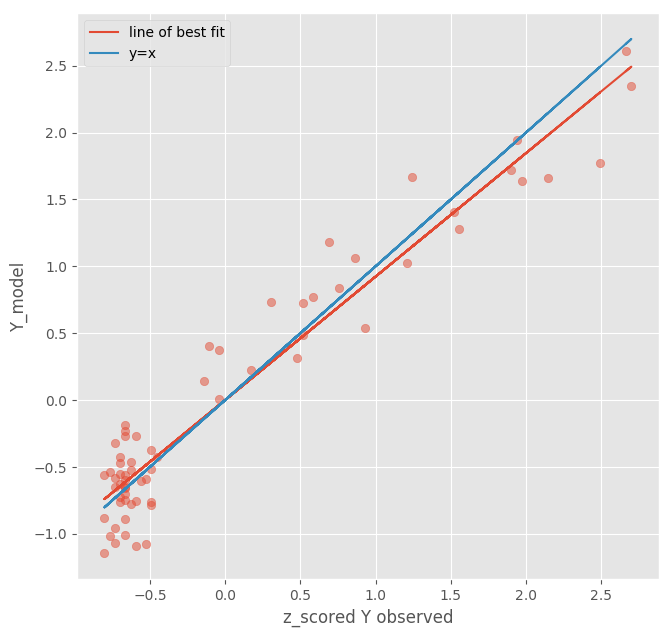


The R-squared value for predicting Y using z-scored observed X and evaluating against observed Y is 0.9605
The Cosgrove et al. defined R-squared value is 0.9232
The Pearson product-moment correlation coefficient is 0.9608
The line of best fit has the following equation  
0.9232 x + 0.2239



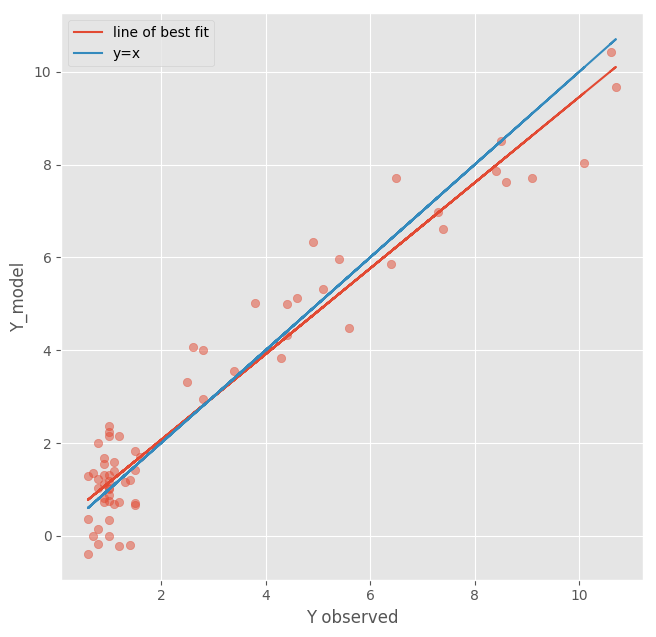

In [9]:
#Y_model_trash = np.squeeze(pls4.predict(X))
Y_model_kinda_zscored = np.squeeze(pls4.predict(X_zscored))
Y_model_kinda_unzscored = [Y_std*y + Y_mean for y in Y_model_kinda_zscored]

'''

I've defined my R_2 function up above:

One minus the ratio of the sum of the squared residuals over the sum of the squared observed.

def one_minus_ratio(A_model, A_observed):
    # np.subtract ~ element-wise subtraction 
    # np.square ~ element-wise squaring
    # np.sum ~ sum of all elements
    
    sum_of_squared_differences = np.sum(np.square(np.squeeze(np.subtract(A_model,A_observed))))
    squared_observed = np.sum(np.square(A_observed))
    
    #print("Results for one_minus_ratio function:")
    #print("observed shape: {}".format(A_observed.shape))
    #print("model shape: {}\n".format(A_model.shape))
    
    return(1-(sum_of_squared_differences/squared_observed))

# tests for function: one_minus_ratio
assert(one_minus_ratio(X_zscored,X_zscored)==1)
assert(one_minus_ratio(Y_zscored,Y_zscored)==1)
assert(one_minus_ratio(X_zscored,X)!=1)
assert(one_minus_ratio(Y_zscored,Y)!=1)

The function below is the one defined in Cosgrove et al.'s paper:

'''

def cosgrove_model_R_squared(A_model, A_observed):
    sum_of_squared_differences = np.sum(np.square(np.squeeze(np.subtract(A_model,A_observed))))
    sum_of_squared_predicted = np.sum(np.square(A_model))
    square_of_summed_predicted = np.square(np.sum(A_model))
    n = len(A_observed)
    
    return(1-(sum_of_squared_differences/(sum_of_squared_predicted-(square_of_summed_predicted/n))))

#coeff_trash = np.polyfit(Y, Y_model_trash, deg=1)
#line_trash = np.poly1d(coeff_trash)
coeff_kinda_zscored = np.polyfit(Y_zscored, Y_model_kinda_zscored, deg=1)
line_kinda_zscored = np.poly1d(coeff_kinda_zscored)
coeff_kinda_unzscored = np.polyfit(Y, Y_model_kinda_unzscored, deg=1)
line_kinda_unzscored = np.poly1d(coeff_kinda_unzscored)


#plt.figure(4, figsize=(7.5, 7.5), dpi=100)

#print("\nThe R-squared value for predicting Y using observed X and evaluating against observed Y is {}".format((round(one_minus_ratio(Y, Y_model_trash), 4))))
#print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y, Y_model_trash), 4))))
#print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y,Y_model_trash)[1,0], 4)))
#print("The line of best fit has the following equation {}\n".format(line_trash))
#plt.scatter(Y, Y_model_trash, alpha=0.5)
#plt.plot(Y, line_trash(Y))
#plt.plot(Y, Y)

#plt.show()

plt.figure(5, figsize=(7.5, 7.5), dpi=100)

print("\nThe R-squared value for predicting z-scored Y using z-scored observed X and evaluating against z-scored observed Y is {}".format((round(one_minus_ratio(Y_zscored, Y_model_kinda_zscored), 4))))
print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y_zscored, Y_model_kinda_zscored), 4))))
print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y_zscored,Y_model_kinda_zscored)[1,0], 4)))
print("The line of best fit has the following equation {}\n".format(line_kinda_zscored))
plt.scatter(Y_zscored, Y_model_kinda_zscored, alpha=0.5)
plt.plot(Y_zscored, line_kinda_zscored(Y_zscored), label="line of best fit")
plt.plot(Y_zscored, Y_zscored, label="y=x")
plt.legend()
plt.xlabel("z_scored Y observed")
plt.ylabel("Y_model")

plt.show()

plt.figure(6, figsize=(7.5, 7.5), dpi=100)

print("\nThe R-squared value for predicting Y using z-scored observed X and evaluating against observed Y is {}".format((round(one_minus_ratio(Y, Y_model_kinda_unzscored), 4))))
print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y, Y_model_kinda_unzscored), 4))))
print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y,Y_model_kinda_unzscored)[1,0], 4)))
print("The line of best fit has the following equation {}\n".format(line_kinda_unzscored))
plt.scatter(Y, Y_model_kinda_unzscored, alpha=0.5)
plt.plot(Y, line_kinda_unzscored(Y), label="line of best fit")
plt.plot(Y, Y, label="y=x")
plt.legend()
plt.xlabel("Y observed")
plt.ylabel("Y_model")

plt.show()

#### (5) Cosgrove reported that the 4-phosphoprotein model chosen, based on VIP scores, accurately reproduces LDH release. To determine if the VIP score improved the selection of reduced parameter sets, choose 4 phosphoproteins at random (keeping all measurements per phosphoprotein) and calculate the fitness by calculating the R^2 value for each set. Repeat this 100 times and calculate the model fitness (R^2) and plot the histogram of these values. Do you think the VIP-score based model reduction is better than random selections? Why/ why not? Do you need to keep track of the 100 subsets chosen in your random trials to prevent choosing the same subset? Why/why not?

In [10]:
# Answer - skipping

#### (6) Cosgrove et al. Discusses their method for model validation using leave- one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

In [11]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

Y_loo_model_kinda_zscored_holder = []
Y_test_zscored_holder = []
Y_loo_model_kinda_unzscored_holder = []
Y_test_holder = []

for train_index, test_index in loo.split(X, Y):
    X_train, X_test = (X)[train_index], (X)[test_index]
    Y_train, Y_test = (Y)[train_index], (Y)[test_index]
    
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)
    X_train_zscored = scipy.stats.mstats.zscore(X_train, axis=0)
    X_test_zscored = (X_test-X_train_mean) / X_train_std
    
    Y_train_mean = np.mean(Y_train)
    Y_train_std = np.std(Y_train)
    Y_train_zscored = scipy.stats.mstats.zscore(Y_train, axis=0)
    Y_test_zscored = (Y_test-Y_train_mean) / Y_train_std
    
    pls4loo = PLSRegression(n_components=(4), max_iter=500)
    pls4loo.fit(X_train_zscored,Y_train_zscored)
    
    Y_loo_model_kinda_zscored = pls4loo.predict(X_test_zscored)
    Y_loo_model_kinda_zscored_holder.append(Y_loo_model_kinda_zscored)
    Y_test_zscored_holder.append(Y_test_zscored)
    
    Y_loo_model_kinda_unzscored = Y_train_std*Y_loo_model_kinda_zscored + Y_train_mean
    Y_loo_model_kinda_unzscored_holder.append(Y_loo_model_kinda_unzscored)
    Y_test_holder.append(Y_test)

Y_loo_model_kinda_zscored_holder = np.squeeze(np.asarray(Y_loo_model_kinda_zscored_holder))
Y_loo_model_kinda_unzscored_holder = np.squeeze(np.asarray(Y_loo_model_kinda_unzscored_holder))
Y_test_zscored_holder = np.squeeze(np.asarray(Y_test_zscored_holder))
Y_test_holder = np.squeeze(np.asarray(Y_test_holder))

print("\nThe R-squared value for predicting z-scored Y using z-scored X_train and evaluating against z-scored Y_test is {}".format((round(one_minus_ratio(Y_test_zscored_holder, Y_loo_model_kinda_zscored_holder), 4))))
print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y_test_zscored_holder, Y_loo_model_kinda_zscored_holder), 4))))
print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y_test_zscored_holder,Y_loo_model_kinda_zscored_holder)[1,0], 4)))

print("\nThe R-squared value for predicting Y using z-scored X_train and evaluating against Y_test is {}".format((round(one_minus_ratio(Y_test_holder, Y_loo_model_kinda_unzscored_holder), 4))))
print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y_test_holder, Y_loo_model_kinda_unzscored_holder), 4))))
print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y_test_holder,Y_loo_model_kinda_unzscored_holder)[1,0], 4)))

#print("\nThe R-squared value for predicting z-scored Y using z-scored X_train and evaluating against Y_test is {}".format((round(one_minus_ratio(Y_test_holder, Y_loo_model_kinda_zscored_holder), 4))))
#print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y_test_holder, Y_loo_model_kinda_zscored_holder), 4))))
#print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y_test_holder,Y_loo_model_kinda_zscored_holder)[1,0], 4)))



The R-squared value for predicting z-scored Y using z-scored X_train and evaluating against z-scored Y_test is -24.8768
The Cosgrove et al. defined R-squared value is 0.2209
The Pearson product-moment correlation coefficient is 0.7318

The R-squared value for predicting Y using z-scored X_train and evaluating against Y_test is 0.2779
The Cosgrove et al. defined R-squared value is 0.1992
The Pearson product-moment correlation coefficient is 0.6848


I calculated the $R^2$ but I can't explain why they are so low. I'm not too confident that I am comparing the two right things.

It's important to perform cross validation because one often needs to prevent overfitting to the given model and be able to predict on new data. PLSR is heavily focused on finding variation within a given dataset, so the model it outputs is heavily dependent on what data is left out and what isn't. We need a model, and a set of data, that exhibit the covariances we want to see and cross-validation lets us evaluate that.

#### (7) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

In [13]:
from sklearn.model_selection import LeaveOneGroupOut
#print(conditions)
#print(cytokineList)
groups = [1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6]
logo = LeaveOneGroupOut()
print(logo.get_n_splits(X, Y, groups)) # should be 6

Y_logo_model_kinda_zscored_holder = []
Y_logo_test_zscored_holder = []
Y_logo_model_kinda_unzscored_holder = []
Y_logo_test_holder = []

for train_index, test_index in logo.split(X, Y, groups):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
        
    X_train_mean = np.mean(X_train)
    X_train_std = np.std(X_train)
    X_train_zscored = scipy.stats.mstats.zscore(X_train, axis=0)
    X_test_zscored = (X_test-X_train_mean) / X_train_std
    
    Y_train_mean = np.mean(Y_train)
    Y_train_std = np.std(Y_train)
    Y_train_zscored = scipy.stats.mstats.zscore(Y_train, axis=0)
    Y_test_zscored = (Y_test-Y_train_mean) / Y_train_std
    
    pls4logo = PLSRegression(n_components=(4), max_iter=500)
    pls4logo.fit(X_train_zscored,Y_train_zscored)
    
    Y_logo_model_kinda_zscored = pls4logo.predict(X_test_zscored)
    Y_logo_model_kinda_zscored_holder.append(Y_logo_model_kinda_zscored)
    Y_logo_test_zscored_holder.append(Y_test_zscored)
    
    Y_logo_model_kinda_unzscored = [Y_train_std*y + Y_train_mean for y in Y_logo_model_kinda_zscored]
    Y_logo_model_kinda_unzscored_holder.append(Y_logo_model_kinda_unzscored)
    Y_logo_test_holder.append(Y_test)

Y_logo_model_kinda_zscored_holder = np.squeeze(np.asarray(Y_logo_model_kinda_zscored_holder))
Y_logo_model_kinda_zscored_holder = np.reshape(Y_logo_model_kinda_zscored_holder, 66)
Y_logo_model_kinda_unzscored_holder = np.squeeze(np.asarray(Y_logo_model_kinda_unzscored_holder))
Y_logo_model_kinda_unzscored_holder = np.reshape(Y_logo_model_kinda_unzscored_holder, 66)
Y_logo_test_zscored_holder = np.squeeze(np.asarray(Y_logo_test_zscored_holder))
Y_logo_test_zscored_holder = np.reshape(Y_logo_test_zscored_holder, 66)
Y_logo_test_holder = np.squeeze(np.asarray(Y_logo_test_holder))
Y_logo_test_holder = np.reshape(Y_logo_test_holder, 66)

print("\nThe R-squared value for predicting z-scored Y using z-scored X_train and evaluating against z-scored Y_test is {}".format((round(one_minus_ratio(Y_logo_test_zscored_holder, Y_logo_model_kinda_zscored_holder), 4))))
print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y_logo_test_zscored_holder, Y_logo_model_kinda_zscored_holder), 4))))
print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y_logo_test_zscored_holder,Y_logo_model_kinda_zscored_holder)[1,0], 4)))

print("\nThe R-squared value for predicting Y using z-scored X_train and evaluating against Y_test is {}".format((round(one_minus_ratio(Y_logo_test_holder, Y_logo_model_kinda_unzscored_holder), 4))))
print("The Cosgrove et al. defined R-squared value is {}".format((round(cosgrove_model_R_squared(Y_logo_test_holder, Y_logo_model_kinda_unzscored_holder), 4))))
print("The Pearson product-moment correlation coefficient is {}".format(round(np.corrcoef(Y_logo_test_holder,Y_logo_model_kinda_unzscored_holder)[1,0], 4)))


6

The R-squared value for predicting z-scored Y using z-scored X_train and evaluating against z-scored Y_test is -6.4222
The Cosgrove et al. defined R-squared value is 0.0921
The Pearson product-moment correlation coefficient is 0.321

The R-squared value for predicting Y using z-scored X_train and evaluating against Y_test is 0.3358
The Cosgrove et al. defined R-squared value is 0.0727
The Pearson product-moment correlation coefficient is 0.2986


LOOCV focuses on taking one sample out and training and evaluating on the rest of the data. LOGO focuses on taking out one group of the data (based on an attribute) and then trains and evaluates on the rest of the data. LOOCV doesn't do much about the interdependence between the data but does focus on evaluating the fit of our model based on all the given data. What LOGO does do is check on the dependence between samples in our data (since some samples might depend each other) and then evaulates the fit of our model. We want to evaulate on independent groups of our data, and LOGO lets us do that.